The linear transport equation for is given by:

$$
( \Omega \subset \mathbb{R} )  \ 

\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0, \quad \text{on } \Omega \times (0, T)
$$

with boundary and initial conditions:

$$
u(b, t) = g(t), \quad t \in (0, T),
$$

$$
u(x, 0) = u_0(x), \quad x \in \Omega.
$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
def exact_lin_transport(u0,g,x,t,c):
    if t ==0:
        return u0(t)
    elif x/t <= c:
        return u0(x-c*t)
    else:
        return g(t-x/c)
# exact solution view in class

In [3]:
class Mesh():
    def __init__(self,N,b):
        self.N = N
        self.b = b
        self.dx = b/N
        self.Nf = N+1
        self.xi = [(i + 0.5) * self.dx for i in range( N)]
        self.xi_05 = [i * self.dx for i in range(self.N)]
        


In [4]:
def RS_transport(uL,uR,c):
    if c > 0:
        return uR
    else :
        return uL
    
def NumFlux_Godunov(uL,uR,c):
    if c > 0 :
        return uL
    else :
        return uR 

In [5]:


def Godunov_scheme(mesh, u0, dt, T, c,g):
    u = np.zeros(len(mesh.xi))
    u = np.array([u0(x) for x in mesh.xi])
    Nt = int(T / dt)
    
    for t in range(Nt):
        u_new = np.zeros_like(u)
        for i in range(1,mesh.N-1):
            u_new[i] = u[i] - (dt / mesh.dx) * (NumFlux_Godunov(u[i], u[i+1], c) - NumFlux_Godunov(u[i-1], u[i], c))
        u_new[0] = g(t*dt)
        u = u_new.copy() 


    return u



In [6]:
def u0(x):
    return 0  

def g1(t):
    return np.sin(2 * np.pi * t)  
    
def g2(t):
    return np.sin(2 * np.pi * t) + 1  

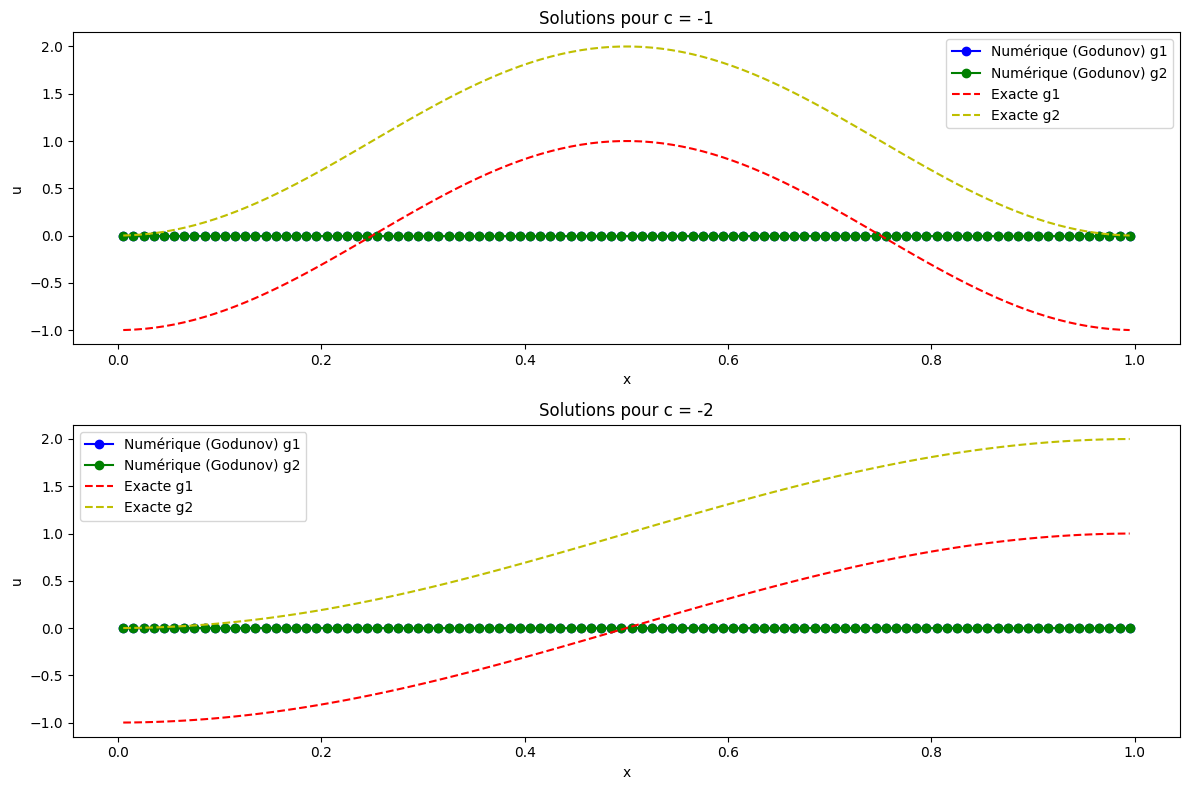

In [7]:

N = 100  
b = 1  
T = 0.75 
mesh = Mesh(N, b)

dx = mesh.dx
dt = 0.5 * dx 

c1 = -1
u_num1 = Godunov_scheme(mesh, u0, dt, T, c1,g1)  
u_num2 = Godunov_scheme(mesh, u0, dt, T, c1,g2)  

c2 = -2
u_num3 = Godunov_scheme(mesh, u0 , dt, T, c2,g1)  
u_num4 = Godunov_scheme(mesh, u0 , dt, T, c2,g2)  


x = np.array(mesh.xi)

u_exact1_g1 = np.array([exact_lin_transport(u0, g1, xi, T, c1) for xi in x])
u_exact1_g2 = np.array([exact_lin_transport(u0, g2, xi, T, c1) for xi in x])

u_exact2_g1 = np.array([exact_lin_transport(u0, g1, xi, T, c2) for xi in x])
u_exact2_g2 = np.array([exact_lin_transport(u0, g2, xi, T, c2) for xi in x])

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(x, u_num1, 'bo-', label='Numérique (Godunov) g1')
plt.plot(x, u_num2, 'go-', label='Numérique (Godunov) g2')
plt.plot(x, u_exact1_g1, 'r--', label='Exacte g1')
plt.plot(x, u_exact1_g2, 'y--', label='Exacte g2')
plt.title("Solutions pour c = -1")
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, u_num3, 'bo-', label='Numérique (Godunov) g1')
plt.plot(x, u_num4, 'go-', label='Numérique (Godunov) g2')
plt.plot(x, u_exact2_g1, 'r--', label='Exacte g1')
plt.plot(x, u_exact2_g2, 'y--', label='Exacte g2')
plt.title("Solutions pour c = -2")
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

plt.tight_layout()
plt.show()

I have some issue with the godunov scheme, i find it hard to understand how the the scheme spread value different from 0 with out initial condition, as we take u_i u_i+1 and u_i-1 from our u.
So in :  
  

u_new[i] = u[i] - (dt / mesh.dx) * (NumFlux_Godunov(u[i], u[i+1], c) - NumFlux_Godunov(u[i-1], u[i], c))  
  
  
u[i] is 0, Numflux_godunov choose between 0 and 0 so u at t+1 time cannot change. So i suppose i missunderstood how to implemented the initial condition or my scheme.


In [8]:
#Muscl scheme
def minmod(alpha,beta,gamma):
    if alpha>0 and beta > 0 and gamma >0:
        return min(alpha,beta,gamma)
    elif alpha <0 and beta < 0 and gamma <0:
        return max(alpha,beta,gamma)
    else: 
        return 0
    
def slopes(u,dx):
    n = len(u)
    s = np.zeros(n)
    for i in range (n-1):
        alpha = (u[i] - u[i - 1] )/dx
        beta = (u[i + 1] - u[i] ) / dx 
        gamma = (u[i+1] - u[i-1]) / 2 *dx
        s[i] = minmod(alpha, beta, gamma)
    return s 

def MUSCL_scheme(mesh,u0,dt,T,c,g):
    u = np.array([u0(x) for x in mesh.xi])
    Nt = int(T / dt)
    

    for t in range(Nt):
        s = slopes(u,mesh.dx)
        u_new = np.zeros_like(u)

        for i in range(1,mesh.N-1):
            Ui_05_plus = u[i] + mesh.dx/2 * s[i]
            Ui_05_moins = u[i+1] + mesh.dx/2 * s[i]

            u_new[i] = u[i] + dt/mesh.dx * (Ui_05_plus- Ui_05_moins)
        
        u_new[0] = g(t*dt)
        u = u_new.copy() 

    return u



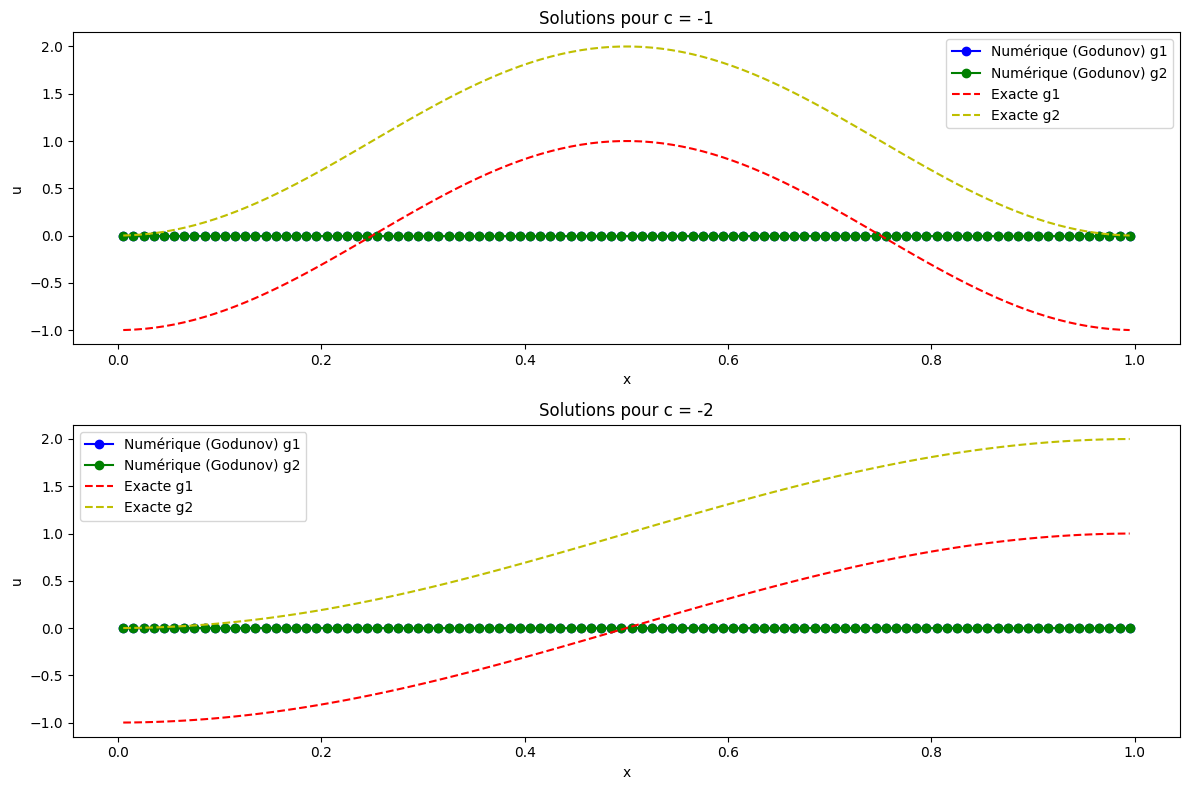

In [9]:
N = 100  
b = 1  
T = 0.75 
mesh = Mesh(N, b)

dx = mesh.dx
dt = 0.5 * dx 

c1 = -1
u_num1 = MUSCL_scheme(mesh, u0, dt, T, c1,g1)  
u_num2 = MUSCL_scheme(mesh, u0, dt, T, c1,g2)  

c2 = -2
u_num3 = MUSCL_scheme(mesh, u0 , dt, T, c2,g1)  
u_num4 = MUSCL_scheme(mesh, u0 , dt, T, c2,g2)  


x = np.array(mesh.xi)

u_exact1_g1 = np.array([exact_lin_transport(u0, g1, xi, T, c1) for xi in x])
u_exact1_g2 = np.array([exact_lin_transport(u0, g2, xi, T, c1) for xi in x])

u_exact2_g1 = np.array([exact_lin_transport(u0, g1, xi, T, c2) for xi in x])
u_exact2_g2 = np.array([exact_lin_transport(u0, g2, xi, T, c2) for xi in x])

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(x, u_num1, 'bo-', label='Numérique (Godunov) g1')
plt.plot(x, u_num2, 'go-', label='Numérique (Godunov) g2')
plt.plot(x, u_exact1_g1, 'r--', label='Exacte g1')
plt.plot(x, u_exact1_g2, 'y--', label='Exacte g2')
plt.title("Solutions pour c = -1")
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, u_num3, 'bo-', label='Numérique (Godunov) g1')
plt.plot(x, u_num4, 'go-', label='Numérique (Godunov) g2')
plt.plot(x, u_exact2_g1, 'r--', label='Exacte g1')
plt.plot(x, u_exact2_g2, 'y--', label='Exacte g2')
plt.title("Solutions pour c = -2")
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

plt.tight_layout()
plt.show()

I probably got the same issue as with the Godunuv scheme.

Exercice 2 


We aim to derive an admissible weak solution for the following initial value problem (IVP):

The partial differential equation (PDE) is:
$$
\partial_t u + \partial_x \left( \frac{u^2}{2} \right) = 0, \quad \text{for } (x, t) \in (-1, 2) \times (0, T),
$$

with the boundary condition:
$$
u(-1, t) = 1, \quad \text{for } t \in (0, T),
$$

and the initial condition:
$$
u(x, 0) =
\begin{cases}
1 & \text{if } x < 0, \\
1 - x & \text{if } 0 \leq x \leq 1, \\
0 & \text{if } x > 1.
\end{cases}
$$


Our goal is to find an admissible weak solution to this problem.



In [10]:
def d_flux(x):
    return x

def inv_flux(y):
    return abs(y*2)**0.5

def RS_nonlinear(uR,uL,xi):
    if d_flux(uL) > xi:
        return uL
    elif d_flux(uR) <= xi <= d_flux(uL):
        return inv_flux(xi)
    else :
        return uR
# justification pdf 
    